# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Добавим необходимые библиотеки.

In [1]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
#pandas для работы с датафреймами
import pandas as pd
#математические библиотеки
import math
import numpy as np
#графики
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
#phik
import phik
#sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import (
    mean_squared_error,
    make_scorer
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
#lgmb
from lightgbm import LGBMRegressor
# регулярные выражения
import re

## Подготовка данных

Загрузим данные.

In [4]:
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Приведём столбцы к змеиному регистру.

In [5]:
# код ревьюера
data = data.rename(columns=lambda x: re.sub(r'(?<!^)([A-Z])', r'_\1', x).lower()) 

Рассмотрим датафрейм методом info.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

Проверим уникальные значения столбцов VehicleType, Gearbox, FuelType и Brand на уникальные значения чтобы привести похожие названия к одному виду.

In [7]:
data['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [8]:
data['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [9]:
data['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Petrol и gasoline это бензин, в разных странах используют разные термины, поэтому заменим petrol на gasoline.

In [10]:
data.loc[data['fuel_type'] == 'petrol', 'fuel_type'] = 'gasoline'
data['fuel_type'].unique()

array(['gasoline', nan, 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

In [11]:
data['brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

Видно что есть одинаковые названия у rover и land_rover, заменим rover на land_rover

In [12]:
data.loc[data['brand'] == 'rover', 'brand'] = 'land_rover'
data['brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'land_rover', 'lada'], dtype=object)

In [13]:
data['repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

Найдём количетво пропусков.

In [14]:
data.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Чтобы заполнить пропуски необходимо проанализировать каждый столбец.

Рассмотрим столбцы VehicleType. Разные компании делают разные автомобили, поэтому нельзя заменить эти столбцы каким-то одним типом. Можно составить сводную таблицу, найти какой тип компания делает больше всего и заменить на этот тип.

Поступим так для колонки VehicleType.

In [15]:
data_pivot_brand = data.pivot_table(index='vehicle_type', columns='brand', values='registration_year', aggfunc='count')
data_pivot_brand

brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
vehicle_type,,,,,,,,,,,,,,,,,,,,,
bus,NaN,10.0,7.0,159.0,436.0,1262.0,50.0,27.0,36.0,833.0,...,614.0,231.0,1.0,202.0,17.0,28.0,447.0,NaN,9536.0,NaN
convertible,180.0,1627.0,3266.0,17.0,238.0,114.0,NaN,1.0,17.0,520.0,...,NaN,4.0,1132.0,330.0,1.0,36.0,65.0,37.0,2963.0,75.0
coupe,229.0,1499.0,3809.0,90.0,48.0,152.0,NaN,8.0,NaN,177.0,...,87.0,10.0,341.0,230.0,8.0,8.0,232.0,4.0,1784.0,69.0
other,15.0,110.0,242.0,46.0,10.0,121.0,6.0,5.0,12.0,184.0,...,74.0,26.0,9.0,256.0,6.0,14.0,21.0,7.0,760.0,5.0
sedan,945.0,10965.0,17585.0,231.0,295.0,714.0,103.0,107.0,47.0,904.0,...,1781.0,911.0,29.0,486.0,168.0,183.0,895.0,230.0,19738.0,643.0
small,239.0,1571.0,448.0,582.0,12.0,1590.0,223.0,268.0,527.0,5308.0,...,3119.0,1124.0,3267.0,261.0,119.0,985.0,1588.0,58.0,18531.0,7.0
suv,1.0,180.0,818.0,384.0,23.0,36.0,215.0,1.0,49.0,24.0,...,4.0,173.0,NaN,429.0,62.0,749.0,445.0,1.0,1331.0,221.0
wagon,457.0,11081.0,7929.0,110.0,244.0,629.0,252.0,47.0,17.0,455.0,...,399.0,2709.0,9.0,139.0,300.0,89.0,572.0,79.0,12660.0,1989.0


Найдём тип кузова для каждого бренда.

In [16]:
data_brand_max = data_pivot_brand.idxmax()
data_brand_max

brand
alfa_romeo              sedan
audi                    wagon
bmw                     sedan
chevrolet               small
chrysler                  bus
citroen                 small
dacia                   wagon
daewoo                  small
daihatsu                small
fiat                    small
ford                    small
honda                   sedan
hyundai                 small
jaguar                  sedan
jeep                      suv
kia                       suv
lada                      suv
lancia                  small
land_rover                suv
mazda                   sedan
mercedes_benz           sedan
mini                    small
mitsubishi              sedan
nissan                  small
opel                    small
peugeot                 small
porsche           convertible
renault                 small
saab                    sedan
seat                    small
skoda                   wagon
smart                   small
sonstige_autos          sedan
suba

Преобразуем эту переменную в словарь.

In [17]:
data_brand_dict = data_brand_max.to_dict()
data_brand_dict

{'alfa_romeo': 'sedan',
 'audi': 'wagon',
 'bmw': 'sedan',
 'chevrolet': 'small',
 'chrysler': 'bus',
 'citroen': 'small',
 'dacia': 'wagon',
 'daewoo': 'small',
 'daihatsu': 'small',
 'fiat': 'small',
 'ford': 'small',
 'honda': 'sedan',
 'hyundai': 'small',
 'jaguar': 'sedan',
 'jeep': 'suv',
 'kia': 'suv',
 'lada': 'suv',
 'lancia': 'small',
 'land_rover': 'suv',
 'mazda': 'sedan',
 'mercedes_benz': 'sedan',
 'mini': 'small',
 'mitsubishi': 'sedan',
 'nissan': 'small',
 'opel': 'small',
 'peugeot': 'small',
 'porsche': 'convertible',
 'renault': 'small',
 'saab': 'sedan',
 'seat': 'small',
 'skoda': 'wagon',
 'smart': 'small',
 'sonstige_autos': 'sedan',
 'subaru': 'wagon',
 'suzuki': 'small',
 'toyota': 'small',
 'trabant': 'sedan',
 'volkswagen': 'sedan',
 'volvo': 'wagon'}

Заполним пропуски для каждого бренда.

In [18]:
for br in data['brand'].unique(): #возможно это антипаттерн, но я не понял как сделать лучше
    data.loc[data['brand'] == br, 'vehicle_type'] = data.loc[data['brand'] == br, 'vehicle_type'].fillna(data_brand_dict[br])

In [19]:
data['vehicle_type'].isna().sum()

0

Рассмотрим столбец FuelType. Чаще всего машины используют бензин, поэтому заполним пропуски бензином.

In [20]:
data['fuel_type'] = data['fuel_type'].fillna('gasoline')
data['fuel_type'].isna().sum()

0

In [21]:
data.isna().sum()

date_crawled              0
price                     0
vehicle_type              0
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type                 0
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Рассмотрим столбец Gearbox. Посмотрим тип коробки передач, которой больше.

In [22]:
data['gearbox'].value_counts()

manual    268251
auto       66285
Name: gearbox, dtype: int64

Больше механической, поэтому заменим пропуски на manual.

In [23]:
data['gearbox'] = data['gearbox'].fillna('manual')
data['gearbox'].isna().sum()

0

Рассмотрим столбец Repaired. Скорее всего пропуски означают, что машина не ремонтировалась, поэтому заменим пропуски на no.

In [24]:
data['repaired'] = data['repaired'].fillna('no')
data['repaired'].isna().sum()

0

Остался столбец Model, неизвестно какая конкретно модель у каждого автомобиля, поэтому пропуски придётся оставить.

Найдём аномалии в количественных переменных с помощью гистограмм.

Рассмотрим столбец Power.

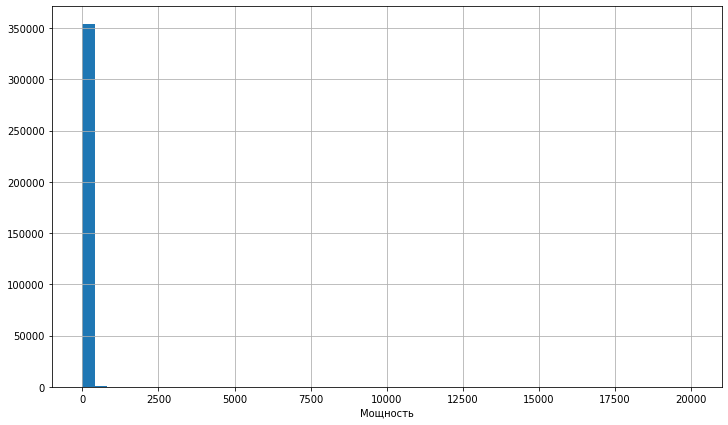

In [25]:
ax = data['power'].hist(
    bins=50,
    figsize=(12, 7)
)
ax.set_xlabel('Мощность');

Виднеется аномалия, удалим её

In [26]:
data = data.query('power < 600')

Построим гистограмму для новых данных

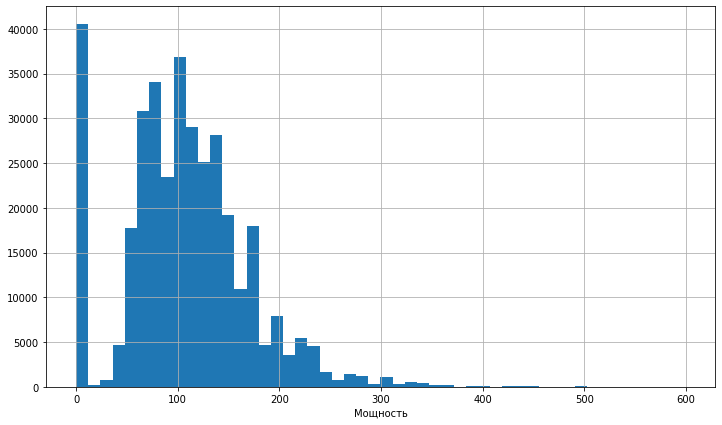

In [27]:
ax = data['power'].hist(
    bins=50,
    figsize=(12, 7)
)
ax.set_xlabel('Мощность');

Очевидно мощность не может равняться нулю, исправим это

In [28]:
data = data.query('power > 0')

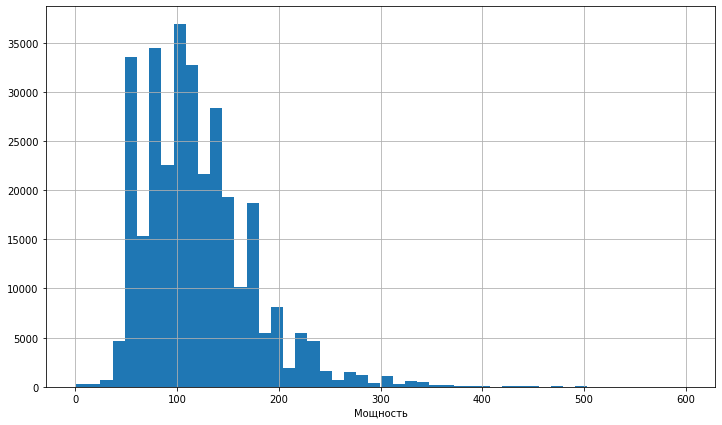

In [29]:
ax = data['power'].hist(
    bins=50,
    figsize=(12, 7)
)
ax.set_xlabel('Мощность');

Рассмотрим пробег.

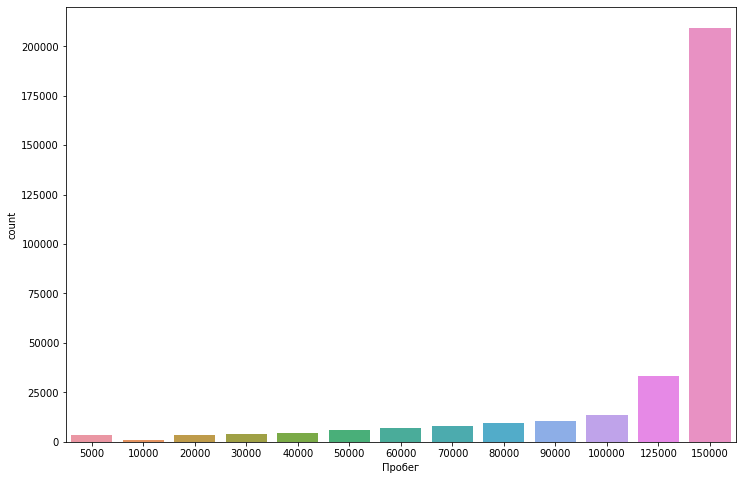

In [30]:
plt.figure(figsize=(12, 8))
ax = sns.countplot(data=data, x='kilometer')
ax.set_xlabel('Пробег');

Рассмотрим дату регистрации

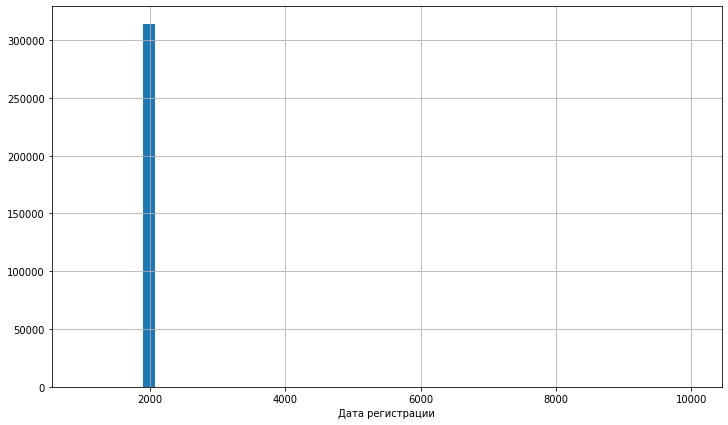

In [31]:
ax = data['registration_year'].hist(
    bins=50,
    figsize=(12, 7)
)
ax.set_xlabel('Дата регистрации');

Дата не может быть больше 2016, исправим это.

In [32]:
data = data.query('registration_year < 2016')

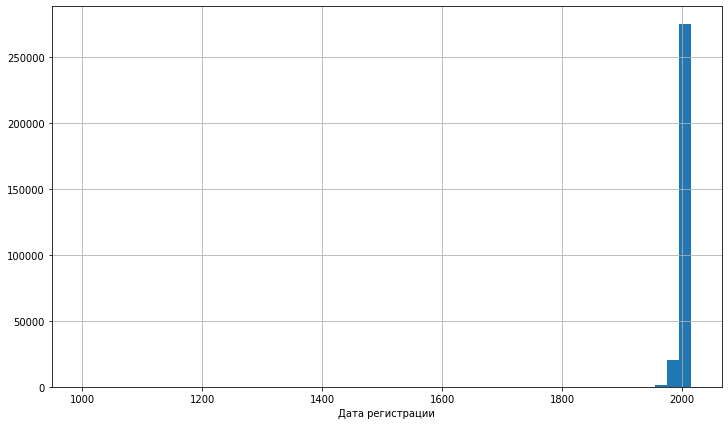

In [33]:
ax = data['registration_year'].hist(
    bins=50,
    figsize=(12, 7)
)
ax.set_xlabel('Дата регистрации');

In [34]:
data = data.query('registration_year > 1950')

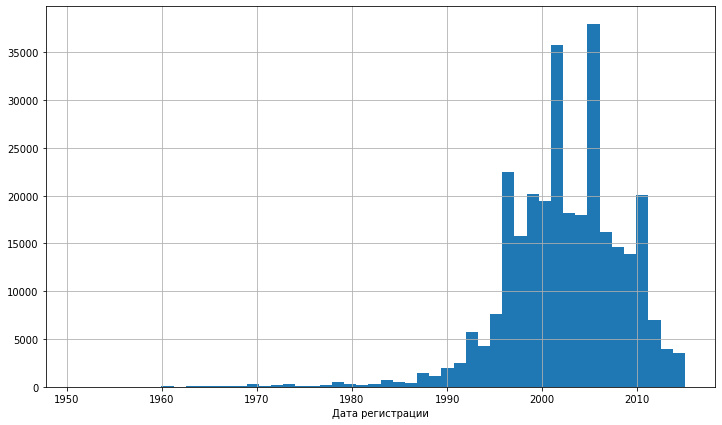

In [35]:
ax = data['registration_year'].hist(
    bins=50,
    figsize=(12, 7)
)
ax.set_xlabel('Дата регистрации');

Была выполнена предобработка, в столбцах brand и fuel_type были разные значения, которые по смыслу являлись одинаковыми, я это исправил. В количественных признаках виднелись аномалии, они были удалены.

## Обучение моделей

Рассмотрим входные признаки и отберём среди них те, которые подходят для машинного обучения.

<font color='red'>
1. DateCrawled. Цена не зависит от даты скачивания анкеты. Не подходит.
    </font>
    <br />
    
<font color='green'>
2. VehicleType. Тип кузова влияет на цену. Подходит.
    </font>
    <br />
    
<font color='green'>
3. RegistrationYear. Год выпуска должен влиять на цену. Подходит.
    </font>
    <br />
    
<font color='green'>
4. Gearbox . Так же влияет на цену. Подходит.
    </font>
    <br />

<font color='green'>
5. Power. Мощность прямо пропорциональна цене. Подходит.
    </font>
    <br />
 
<font color='red'>
6. Model. Моделей автомобилей очень много, к тому же это категориальный признак, это может значительно увеличить время обучения модели. Не подходит.
    </font>
    <br />
  
<font color='green'>
7. Kilometer. Пробег будет влиять на цену так как б/у машины дешевле. Подходит.
    </font>
    <br />
  
<font color='red'>
8. RegistrationMonth. Без привязки к году непонятно как месяц повлияет на модель. Не подходит.
    </font>
    <br />
    
<font color='green'>
9. FuelType. Разные типы топлива должны влиять на цену. Подходит.
    </font>
    <br />
    
<font color='green'>
10. Brand. Очевидно подходит.
    </font>
    <br />
    
<font color='green'>
11. Repaired. Б/у автомобили дешевле. Подходит.
    </font>
    <br />
    
<font color='red'>
12. DateCreated. Показывает данные пользователя, а не автомобиля. Не подходит.
    </font>
    <br />
    
<font color='red'>
13. NumberOfPictures. Показывает сколько фотографий сделал владелец. Не подходит.
    </font>
    <br />
    
<font color='red'>
14. PostalCode. Без привязке к стране почтовых индексов много, это говорит только о пользователе. Не подходит.
    </font>
    <br />
    
<font color='red'>
15. LastSeen. Информация только о пользователе. Не подходит.
    </font>
    <br />

Удалим ненужные столбцы.

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296130 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        296130 non-null  object
 1   price               296130 non-null  int64 
 2   vehicle_type        296130 non-null  object
 3   registration_year   296130 non-null  int64 
 4   gearbox             296130 non-null  object
 5   power               296130 non-null  int64 
 6   model               284995 non-null  object
 7   kilometer           296130 non-null  int64 
 8   registration_month  296130 non-null  int64 
 9   fuel_type           296130 non-null  object
 10  brand               296130 non-null  object
 11  repaired            296130 non-null  object
 12  date_created        296130 non-null  object
 13  number_of_pictures  296130 non-null  int64 
 14  postal_code         296130 non-null  int64 
 15  last_seen           296130 non-null  object
dtypes:

In [37]:
good_data = data.drop(
    ['date_crawled', 'model', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis=1
)
good_data.head()

,price,vehicle_type,registration_year,gearbox,power,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,150000,gasoline,volkswagen,no
4,3600,small,2008,manual,69,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,150000,gasoline,bmw,yes


Построим матрицу корреляции между входными признаками.

interval columns not set, guessing: ['registration_year', 'power', 'kilometer']


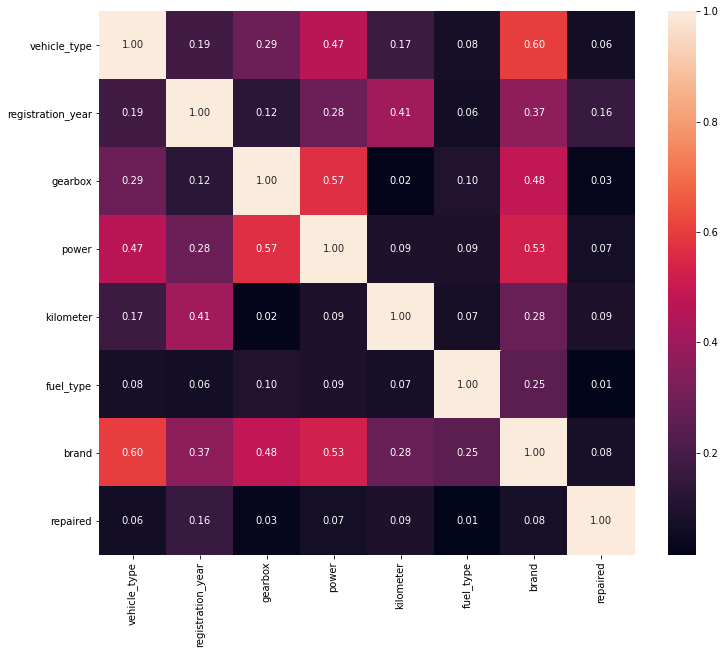

In [38]:
#cat_name = ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired']

cm = good_data.drop('price', axis=1).phik_matrix()
plt.figure(figsize=(12, 10)),
sns.heatmap(cm, annot=True, fmt='.2f');

Среди входных признаков нет сильной корреляции между входными признаками.

Разделим данные.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    good_data.drop(['price'], axis=1),
    good_data['price'],
    random_state = 42
)

Создадим пайплайны для моделей.

Выпишем количественные и категориальные признаки для моделей.

In [40]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222097 entries, 156680 to 145820
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   vehicle_type       222097 non-null  object
 1   registration_year  222097 non-null  int64 
 2   gearbox            222097 non-null  object
 3   power              222097 non-null  int64 
 4   kilometer          222097 non-null  int64 
 5   fuel_type          222097 non-null  object
 6   brand              222097 non-null  object
 7   repaired           222097 non-null  object
dtypes: int64(3), object(5)
memory usage: 15.3+ MB


In [41]:
cat_name = ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired']
num_name = ['kilometer', 'registration_year', 'power']

Создадим пайплайн для категориальных признаков.

In [42]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder( 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

Создадим пайплайн для обработки данных.

In [43]:
data_preprocessor = ColumnTransformer(
    [('ohe', ord_pipe, cat_name),
     ('num', 'passthrough', num_name)
    ], 
    remainder='passthrough'
)

<div class="alert alert-info"> <b>Комментарии студентаV3:</b> Посоветуй пожалуйста материалы для пайплайнов, я с ними не очень разобрался.  </div>

Создадим пайплайн для поиска лучшей модели.

Рассмотрим модель DecisionTreeRegressor.

In [44]:
pipe_final_tree = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', DecisionTreeRegressor(random_state = 42)
    )
])

In [45]:
param_grid_tree = {
        'model__min_samples_split': range(2, 5),
        'model__min_samples_leaf': range(1, 5)
    }

In [46]:
gs_tree = GridSearchCV(
    pipe_final_tree,
    param_grid_tree,
    n_jobs=-1,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=10
)

In [47]:
gs_tree.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START model__min_samples_leaf=1, model__min_samples_split=2......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 1/12] END model__min_samples_leaf=1, model__min_samples_split=2; total time=   1.0s
[CV 2/5; 1/12] START model__min_samples_leaf=1, model__min_samples_split=2......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 1/12] END model__min_samples_leaf=1, model__min_samples_split=2; total time=   1.0s
[CV 3/5; 1/12] START model__min_samples_leaf=1, model__min_samples_split=2......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 1/12] END model__min_samples_leaf=1, model__min_samples_split=2; total time=   1.0s
[CV 4/5; 1/12] START model__min_samples_leaf=1, model__min_samples_split=2......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 1/12] END model__min_samples_leaf=1, model__min_samples_split=2; total time=   1.0s
[CV 5/5; 1/12] START model__min_samples_leaf=1, model__min_samples_split=2......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 1/12] END model__min_samples_leaf=1, model__min_samples_split=2; total time=   1.0s
[CV 1/5; 2/12] START model__min_samples_leaf=1, model__min_samples_split=3......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 2/12] END model__min_samples_leaf=1, model__min_samples_split=3; total time=   1.0s
[CV 2/5; 2/12] START model__min_samples_leaf=1, model__min_samples_split=3......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 2/12] END model__min_samples_leaf=1, model__min_samples_split=3; total time=   1.0s
[CV 3/5; 2/12] START model__min_samples_leaf=1, model__min_samples_split=3......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 2/12] END model__min_samples_leaf=1, model__min_samples_split=3; total time=   1.0s
[CV 4/5; 2/12] START model__min_samples_leaf=1, model__min_samples_split=3......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 2/12] END model__min_samples_leaf=1, model__min_samples_split=3; total time=   0.9s
[CV 5/5; 2/12] START model__min_samples_leaf=1, model__min_samples_split=3......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 2/12] END model__min_samples_leaf=1, model__min_samples_split=3; total time=   0.9s
[CV 1/5; 3/12] START model__min_samples_leaf=1, model__min_samples_split=4......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 3/12] END model__min_samples_leaf=1, model__min_samples_split=4; total time=   0.9s
[CV 2/5; 3/12] START model__min_samples_leaf=1, model__min_samples_split=4......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 3/12] END model__min_samples_leaf=1, model__min_samples_split=4; total time=   0.9s
[CV 3/5; 3/12] START model__min_samples_leaf=1, model__min_samples_split=4......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 3/12] END model__min_samples_leaf=1, model__min_samples_split=4; total time=   0.9s
[CV 4/5; 3/12] START model__min_samples_leaf=1, model__min_samples_split=4......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 3/12] END model__min_samples_leaf=1, model__min_samples_split=4; total time=   0.9s
[CV 5/5; 3/12] START model__min_samples_leaf=1, model__min_samples_split=4......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 3/12] END model__min_samples_leaf=1, model__min_samples_split=4; total time=   1.0s
[CV 1/5; 4/12] START model__min_samples_leaf=2, model__min_samples_split=2......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 4/12] END model__min_samples_leaf=2, model__min_samples_split=2; total time=   0.9s
[CV 2/5; 4/12] START model__min_samples_leaf=2, model__min_samples_split=2......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 4/12] END model__min_samples_leaf=2, model__min_samples_split=2; total time=   0.9s
[CV 3/5; 4/12] START model__min_samples_leaf=2, model__min_samples_split=2......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 4/12] END model__min_samples_leaf=2, model__min_samples_split=2; total time=   0.9s
[CV 4/5; 4/12] START model__min_samples_leaf=2, model__min_samples_split=2......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 4/12] END model__min_samples_leaf=2, model__min_samples_split=2; total time=   1.0s
[CV 5/5; 4/12] START model__min_samples_leaf=2, model__min_samples_split=2......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 4/12] END model__min_samples_leaf=2, model__min_samples_split=2; total time=   0.9s
[CV 1/5; 5/12] START model__min_samples_leaf=2, model__min_samples_split=3......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 5/12] END model__min_samples_leaf=2, model__min_samples_split=3; total time=   0.9s
[CV 2/5; 5/12] START model__min_samples_leaf=2, model__min_samples_split=3......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 5/12] END model__min_samples_leaf=2, model__min_samples_split=3; total time=   0.9s
[CV 3/5; 5/12] START model__min_samples_leaf=2, model__min_samples_split=3......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 5/12] END model__min_samples_leaf=2, model__min_samples_split=3; total time=   0.9s
[CV 4/5; 5/12] START model__min_samples_leaf=2, model__min_samples_split=3......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 5/12] END model__min_samples_leaf=2, model__min_samples_split=3; total time=   0.9s
[CV 5/5; 5/12] START model__min_samples_leaf=2, model__min_samples_split=3......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 5/12] END model__min_samples_leaf=2, model__min_samples_split=3; total time=   0.9s
[CV 1/5; 6/12] START model__min_samples_leaf=2, model__min_samples_split=4......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 6/12] END model__min_samples_leaf=2, model__min_samples_split=4; total time=   0.9s
[CV 2/5; 6/12] START model__min_samples_leaf=2, model__min_samples_split=4......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 6/12] END model__min_samples_leaf=2, model__min_samples_split=4; total time=   0.9s
[CV 3/5; 6/12] START model__min_samples_leaf=2, model__min_samples_split=4......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 6/12] END model__min_samples_leaf=2, model__min_samples_split=4; total time=   1.0s
[CV 4/5; 6/12] START model__min_samples_leaf=2, model__min_samples_split=4......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 6/12] END model__min_samples_leaf=2, model__min_samples_split=4; total time=   0.9s
[CV 5/5; 6/12] START model__min_samples_leaf=2, model__min_samples_split=4......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 6/12] END model__min_samples_leaf=2, model__min_samples_split=4; total time=   1.0s
[CV 1/5; 7/12] START model__min_samples_leaf=3, model__min_samples_split=2......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 7/12] END model__min_samples_leaf=3, model__min_samples_split=2; total time=   0.9s
[CV 2/5; 7/12] START model__min_samples_leaf=3, model__min_samples_split=2......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 7/12] END model__min_samples_leaf=3, model__min_samples_split=2; total time=   0.9s
[CV 3/5; 7/12] START model__min_samples_leaf=3, model__min_samples_split=2......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 7/12] END model__min_samples_leaf=3, model__min_samples_split=2; total time=   0.9s
[CV 4/5; 7/12] START model__min_samples_leaf=3, model__min_samples_split=2......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 7/12] END model__min_samples_leaf=3, model__min_samples_split=2; total time=   0.9s
[CV 5/5; 7/12] START model__min_samples_leaf=3, model__min_samples_split=2......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 7/12] END model__min_samples_leaf=3, model__min_samples_split=2; total time=   0.9s
[CV 1/5; 8/12] START model__min_samples_leaf=3, model__min_samples_split=3......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 8/12] END model__min_samples_leaf=3, model__min_samples_split=3; total time=   0.9s
[CV 2/5; 8/12] START model__min_samples_leaf=3, model__min_samples_split=3......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 8/12] END model__min_samples_leaf=3, model__min_samples_split=3; total time=   0.9s
[CV 3/5; 8/12] START model__min_samples_leaf=3, model__min_samples_split=3......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 8/12] END model__min_samples_leaf=3, model__min_samples_split=3; total time=   0.9s
[CV 4/5; 8/12] START model__min_samples_leaf=3, model__min_samples_split=3......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 8/12] END model__min_samples_leaf=3, model__min_samples_split=3; total time=   0.9s
[CV 5/5; 8/12] START model__min_samples_leaf=3, model__min_samples_split=3......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 8/12] END model__min_samples_leaf=3, model__min_samples_split=3; total time=   0.9s
[CV 1/5; 9/12] START model__min_samples_leaf=3, model__min_samples_split=4......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 9/12] END model__min_samples_leaf=3, model__min_samples_split=4; total time=   0.9s
[CV 2/5; 9/12] START model__min_samples_leaf=3, model__min_samples_split=4......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 9/12] END model__min_samples_leaf=3, model__min_samples_split=4; total time=   0.9s
[CV 3/5; 9/12] START model__min_samples_leaf=3, model__min_samples_split=4......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 9/12] END model__min_samples_leaf=3, model__min_samples_split=4; total time=   0.9s
[CV 4/5; 9/12] START model__min_samples_leaf=3, model__min_samples_split=4......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 9/12] END model__min_samples_leaf=3, model__min_samples_split=4; total time=   0.9s
[CV 5/5; 9/12] START model__min_samples_leaf=3, model__min_samples_split=4......


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 9/12] END model__min_samples_leaf=3, model__min_samples_split=4; total time=   0.9s
[CV 1/5; 10/12] START model__min_samples_leaf=4, model__min_samples_split=2.....


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 10/12] END model__min_samples_leaf=4, model__min_samples_split=2; total time=   0.9s
[CV 2/5; 10/12] START model__min_samples_leaf=4, model__min_samples_split=2.....


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 10/12] END model__min_samples_leaf=4, model__min_samples_split=2; total time=   0.9s
[CV 3/5; 10/12] START model__min_samples_leaf=4, model__min_samples_split=2.....


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 10/12] END model__min_samples_leaf=4, model__min_samples_split=2; total time=   0.9s
[CV 4/5; 10/12] START model__min_samples_leaf=4, model__min_samples_split=2.....


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 10/12] END model__min_samples_leaf=4, model__min_samples_split=2; total time=   0.9s
[CV 5/5; 10/12] START model__min_samples_leaf=4, model__min_samples_split=2.....


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 10/12] END model__min_samples_leaf=4, model__min_samples_split=2; total time=   0.9s
[CV 1/5; 11/12] START model__min_samples_leaf=4, model__min_samples_split=3.....


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 11/12] END model__min_samples_leaf=4, model__min_samples_split=3; total time=   0.9s
[CV 2/5; 11/12] START model__min_samples_leaf=4, model__min_samples_split=3.....


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 11/12] END model__min_samples_leaf=4, model__min_samples_split=3; total time=   0.9s
[CV 3/5; 11/12] START model__min_samples_leaf=4, model__min_samples_split=3.....


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 11/12] END model__min_samples_leaf=4, model__min_samples_split=3; total time=   0.9s
[CV 4/5; 11/12] START model__min_samples_leaf=4, model__min_samples_split=3.....


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 11/12] END model__min_samples_leaf=4, model__min_samples_split=3; total time=   0.9s
[CV 5/5; 11/12] START model__min_samples_leaf=4, model__min_samples_split=3.....


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 11/12] END model__min_samples_leaf=4, model__min_samples_split=3; total time=   0.9s
[CV 1/5; 12/12] START model__min_samples_leaf=4, model__min_samples_split=4.....


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 1/5; 12/12] END model__min_samples_leaf=4, model__min_samples_split=4; total time=   0.9s
[CV 2/5; 12/12] START model__min_samples_leaf=4, model__min_samples_split=4.....


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 2/5; 12/12] END model__min_samples_leaf=4, model__min_samples_split=4; total time=   0.9s
[CV 3/5; 12/12] START model__min_samples_leaf=4, model__min_samples_split=4.....


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 3/5; 12/12] END model__min_samples_leaf=4, model__min_samples_split=4; total time=   0.9s
[CV 4/5; 12/12] START model__min_samples_leaf=4, model__min_samples_split=4.....


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 4/5; 12/12] END model__min_samples_leaf=4, model__min_samples_split=4; total time=   0.9s
[CV 5/5; 12/12] START model__min_samples_leaf=4, model__min_samples_split=4.....


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


[CV 5/5; 12/12] END model__min_samples_leaf=4, model__min_samples_split=4; total time=   0.9s


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_before_ord',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ord',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=nan)),
                                                                                         ('simpleImputer_after_ord',
                               

Найдём метрику на кросс-валидации.

In [48]:
gs_tree.best_score_

-1890.2680811980238

Найдём лучшие параметры.

In [49]:
gs_tree.best_params_

{'model__min_samples_leaf': 4, 'model__min_samples_split': 2}

Найдём время обучения.

Сделаем датафрейм из атрибута cv_results_.

In [50]:
result_tree_data = pd.DataFrame(gs_tree.cv_results_)
result_tree_data

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__min_samples_leaf,param_model__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.890444,0.011742,0.079619,0.002826,1,2,"{'model__min_samples_leaf': 1, 'model__min_sam...",-2060.854163,-2006.998325,-2046.861133,-2066.404651,-2049.431547,-2046.109964,20.835466,12
1,0.873712,0.015379,0.079544,0.005691,1,3,"{'model__min_samples_leaf': 1, 'model__min_sam...",-2035.336010,-1980.775386,-2038.282145,-2041.463717,-2041.297767,-2027.431005,23.435815,11
2,0.870643,0.009336,0.075547,0.003657,1,4,"{'model__min_samples_leaf': 1, 'model__min_sam...",-2009.436896,-1977.643440,-2026.585970,-2019.958838,-2032.334410,-2013.191911,19.336087,10
3,0.853073,0.023011,0.077155,0.006373,2,2,"{'model__min_samples_leaf': 2, 'model__min_sam...",-1943.615286,-1908.966102,-1972.705850,-1958.093128,-1966.403464,-1949.956766,22.692131,7
4,0.844742,0.008210,0.078603,0.004981,2,3,"{'model__min_samples_leaf': 2, 'model__min_sam...",-1943.615286,-1908.966102,-1972.705850,-1958.093128,-1966.403464,-1949.956766,22.692131,7
5,0.869543,0.023503,0.077504,0.002900,2,4,"{'model__min_samples_leaf': 2, 'model__min_sam...",-1943.615286,-1908.966102,-1972.705850,-1958.093128,-1966.403464,-1949.956766,22.692131,7
6,0.835932,0.015753,0.077240,0.002493,3,2,"{'model__min_samples_leaf': 3, 'model__min_sam...",-1917.245226,-1871.899089,-1927.758672,-1915.015694,-1930.099679,-1912.403672,21.070402,4
7,0.823767,0.017252,0.075268,0.009583,3,3,"{'model__min_samples_leaf': 3, 'model__min_sam...",-1917.245226,-1871.899089,-1927.758672,-1915.015694,-1930.099679,-1912.403672,21.070402,4
8,0.854790,0.011619,0.076531,0.003981,3,4,"{'model__min_samples_leaf': 3, 'model__min_sam...",-1917.245226,-1871.899089,-1927.758672,-1915.015694,-1930.099679,-1912.403672,21.070402,4
9,0.825142,0.016022,0.078482,0.003485,4,2,"{'model__min_samples_leaf': 4, 'model__min_sam...",-1890.912153,-1846.355708,-1908.289276,-1893.465041,-1912.318229,-1890.268081,23.451671,1


Выведем время для лучшей модели.

In [51]:
result_tree_data.loc[(result_tree_data['rank_test_score'] == 1) & (result_tree_data['params'] == gs_tree.best_params_)
                     , 'mean_fit_time':'std_score_time']

,mean_fit_time,std_fit_time,mean_score_time,std_score_time
9,0.825142,0.016022,0.078482,0.003485


Время обучения на лучших гиперпараметрах равно 0.801145 секунды.

Поступим аналогично с моделью LGBMRegressor.

Создадим пайплайн для модели.

In [56]:
X_train_lgbm = X_train.copy()
X_train_lgbm[cat_name] = X_train_lgbm[cat_name].astype('category')
X_train_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222097 entries, 156680 to 145820
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   vehicle_type       222097 non-null  category
 1   registration_year  222097 non-null  int64   
 2   gearbox            222097 non-null  category
 3   power              222097 non-null  int64   
 4   kilometer          222097 non-null  int64   
 5   fuel_type          222097 non-null  category
 6   brand              222097 non-null  category
 7   repaired           222097 non-null  category
dtypes: category(5), int64(3)
memory usage: 7.8 MB


In [57]:
param_grid_lgbm = {
        'n_estimators': range(45, 50),
        'num_leaves': range(10, 15),
    }


In [58]:
gs_lgbm = GridSearchCV(
    estimator=LGBMRegressor(random_state=42),
    param_grid=param_grid_lgbm,
    n_jobs=-1,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=10
)

In [2]:
gs_lgbm.fit(X_train_lgbm, y_train)

Найдём метрику на кросс-валидации.

In [60]:
gs_lgbm.best_score_

-1901.5634397144815

Найдём время обучения.

In [61]:
result_lgbm_data = pd.DataFrame(gs_lgbm.cv_results_)
result_lgbm_data.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,12.485084,3.586812,0.195407,0.004771,45,10,"{'n_estimators': 45, 'num_leaves': 10}",-1952.985360,-1910.222338,-1966.530250,-1956.042173,-1981.530542,-1953.462133,23.812497,25
1,12.038996,3.102888,0.201933,0.005725,45,11,"{'n_estimators': 45, 'num_leaves': 11}",-1942.089522,-1891.576223,-1950.668519,-1946.854017,-1968.965012,-1940.030659,25.880457,20
2,19.112879,7.523234,0.182663,0.033459,45,12,"{'n_estimators': 45, 'num_leaves': 12}",-1926.823167,-1887.429938,-1938.577825,-1935.644899,-1957.575764,-1929.210318,23.173481,16
3,17.971698,5.146270,0.206103,0.004467,45,13,"{'n_estimators': 45, 'num_leaves': 13}",-1916.206871,-1875.076307,-1927.914498,-1926.561977,-1948.824428,-1918.916816,24.344223,11
4,16.251927,3.868520,0.204153,0.051257,45,14,"{'n_estimators': 45, 'num_leaves': 14}",-1909.710440,-1867.411677,-1927.890751,-1916.287222,-1939.136164,-1912.087251,24.497307,7


In [62]:
result_lgbm_data.loc[result_lgbm_data['rank_test_score'] == 1, 'mean_fit_time':'std_score_time']

,mean_fit_time,std_fit_time,mean_score_time,std_score_time
24,17.304394,4.682065,0.21906,0.034655


Среднее время обучения составило 17.304394 секунды.

## Анализ моделей

Модель дерева решений оказалась точнее, к тому же она меньше обучалась.

Найдём RMSE на тестовой выборке.

In [63]:
pred = gs_tree.best_estimator_.predict(X_test)

In [64]:
mean_squared_error(y_test, pred, squared=False)

1845.379113237603